In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, MaxPool2D, Conv2D, Dropout, BatchNormalization
from keras.optimizers import RMSprop
## hey

### Getting the train data

In [2]:
df_train = pd.read_csv("train.csv")

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.shape

(42000, 785)

### Getting the test data

In [5]:
df_test = pd.read_csv("test.csv")

In [6]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_test.shape

(28000, 784)

### Let's see what labels we have and how many are in each case

In [8]:
df_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

##### Looks like we have the following labels = 0,1,2,3,4,5,6,7,8,9 , so 10 different labels

### Let's visualize the images

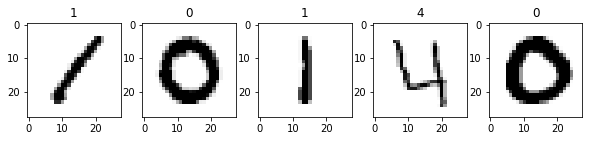

In [9]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    #we localize each row with iloc, then we take everything less the label with [1:], the we convert it to values 
    digit = df_train.iloc[i][1:].values.reshape(28,28)  
    plt.imshow(digit, cmap = 'binary')
    plt.title(df_train.iloc[i][0])

### Make a copy of the dataframe to don't modify the originals 

In [10]:
df_trainc= df_train.copy()
df_testc=df_test.copy()

### Let's define X and Y from the df_train dataset

In [11]:
y = df_trainc['label']
X = df_trainc.drop(labels = ['label'], axis=1)

### Let's see which is the maximum value that you can find in one row of the df_train dataset

In [12]:
df_trainc.iloc[0][1:].values.max()

255

##### The maximum value is 255. If we are training a neural network, for various reasons it's easier if we treat all values as between 0 and 1, therefore we need to normalize our datasets.

### Normalizing 

In [13]:
X  = X / 255.0
df_testc = df_test /255.0

### Reshape

In [14]:
X = X.values.reshape(-1, 28,28,1)
df_testc = df_testc.values.reshape(-1, 28,28,1)

###### https://stackoverflow.com/questions/41848660/why-the-negative-reshape-1-in-mnist-tutorial/41848962

### Label encoding

In [15]:
from keras.utils.np_utils import to_categorical
y = to_categorical(y, num_classes=10)

### Split into train and test

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=2)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (37800, 28, 28, 1) (37800, 10)
Test set: (4200, 28, 28, 1) (4200, 10)


## Callback

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

In [18]:
callbacks = myCallback()

# Modeling 

### a) Simple Model

In [19]:
model = Sequential()
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [20]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon=1e-08, decay =0.0)

In [21]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [22]:
model.fit(X_train, y_train, epochs=10, callbacks=[callbacks])

Epoch 1/10
1182/1182 [==============================] - 6s 5ms/step - loss: 0.3689 - accuracy: 0.8906
Epoch 2/10
1182/1182 [==============================] - 6s 5ms/step - loss: 0.2032 - accuracy: 0.9417
Epoch 3/10
1182/1182 [==============================] - 7s 6ms/step - loss: 0.1715 - accuracy: 0.9519
Epoch 4/10
1182/1182 [==============================] - 5s 4ms/step - loss: 0.1485 - accuracy: 0.9591
Epoch 5/10
1182/1182 [==============================] - 5s 4ms/step - loss: 0.1406 - accuracy: 0.9619
Epoch 6/10
1182/1182 [==============================] - 5s 5ms/step - loss: 0.1370 - accuracy: 0.9647
Epoch 7/10
1182/1182 [==============================] - 4s 4ms/step - loss: 0.1312 - accuracy: 0.9668
Epoch 8/10
1182/1182 [==============================] - 4s 3ms/step - loss: 0.1211 - accuracy: 0.9688
Epoch 9/10
1182/1182 [==============================] - 5s 4ms/step - loss: 0.1244 - accuracy: 0.9692
Epoch 10/10
1182/1182 [==============================] - 5s 4ms/step - loss: 0.115

### Evaluation

In [23]:
model.evaluate(X_test, y_test)

132/132 [==============================] - 0s 2ms/step - loss: 0.1248 - accuracy: 0.9724


[0.12476716190576553, 0.9723809361457825]

### b) Model with double convolutions and pooling

In [24]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size = (5,5), padding = 'Same', activation= 'relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'Same', activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [25]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon=1e-08, decay =0.0)

In [26]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [27]:
model.fit(X_train, y_train, epochs=10, callbacks=[callbacks])

Epoch 1/10
1182/1182 [==============================] - 64s 54ms/step - loss: 0.1812 - accuracy: 0.9432
Epoch 2/10
1182/1182 [==============================] - 55s 47ms/step - loss: 0.0634 - accuracy: 0.9813
Epoch 3/10
1182/1182 [==============================] - 61s 51ms/step - loss: 0.0482 - accuracy: 0.9849
Epoch 4/10
1182/1182 [==============================] - 62s 52ms/step - loss: 0.0427 - accuracy: 0.9885
Epoch 5/10
1182/1182 [==============================] - 54s 46ms/step - loss: 0.0402 - accuracy: 0.9891
Epoch 6/10
1182/1182 [==============================] - 54s 46ms/step - loss: 0.0402 - accuracy: 0.9887
Epoch 7/10
1182/1182 [==============================] - 64s 55ms/step - loss: 0.0398 - accuracy: 0.9890
Epoch 8/10
1182/1182 [==============================] - 67s 57ms/step - loss: 0.0421 - accuracy: 0.9885
Epoch 9/10
1182/1182 [==============================] - 55s 47ms/step - loss: 0.0442 - accuracy: 0.9891
Epoch 10/10
1182/1182 [==============================] - 54s 46m

### Evaluation

In [28]:
model.evaluate(X_test, y_test)

132/132 [==============================] - 1s 10ms/step - loss: 0.0608 - accuracy: 0.9864


[0.060779083520174026, 0.9864285588264465]

### Submition

In [29]:
df_testc.max()

1.0

In [30]:
result = model.predict(df_testc)

In [32]:
result = np.argmax(result, axis=1)

In [33]:
result = pd.Series(result, name='Label')

In [34]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),result],axis = 1)

In [35]:
submission.to_csv("submission_cnn.csv",index=False)

In [36]:
df_submition = pd.read_csv("submission_cnn.csv")

In [37]:
df_submition.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
